# Collaboration and Competition

---

In this notebook, we use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
import numpy as np
import torch
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

from matd3 import MATD3

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### 3. Training Functions

In [5]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def matd3(env, agents, n_episodes=5000):

    scores_all = []
    scores_window = deque(maxlen=100)
    moving_average = []

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        num_agents = len(env_info.agents)
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agents.reset()

        # run the episode
        done = False
        while not done:
            actions = agents.act(states)

            # send the actions to the environment
            env_info = env.step(actions)[brain_name]

            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agents.step(states, actions, rewards, next_states, dones)

            states = next_states
            scores += rewards
            done = np.any(dones)

        max_score = np.max(scores)
        scores_window.append(max_score)
        scores_all.append(max_score)
        average_score = np.mean(scores_window)
        moving_average.append(average_score)

        msg = '\rEpisode {}\tScore: {:.4f}\tAverage Score: {:.4f}'
        print(msg.format(i_episode, max_score, average_score), end=('\n' if i_episode % 100 == 0 else ''))

        if average_score >= 0.5:
            agents.save_model()
            if len(scores_window) >= 100:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, average_score))
                break

    return scores_all, moving_average

### 4. Hyperparameters

In [6]:
config = {
    'SEED': 0,
    'BUFFER_SIZE': int(1e5),    # replay buffer size
    'BATCH_SIZE': 256,          # minibatch size
    'GAMMA': 0.99,              # discount factor
    'TAU': 1e-2,                # for soft update of target parameters
    'LR_ACTOR': 1e-3,           # learning rate of the actor
    'LR_CRITIC': 1e-3           # learning rate of the critic
}

### 5. Instantiate the Agents

In [7]:
seeding(config['SEED'])

agents = MATD3(state_size=state_size, action_size=action_size, num_agents=num_agents, config=config)

### 6. Train the Agents with TD3

In [8]:
scores, mov_avgs = matd3(env, agents)

Episode 100	Score: 0.1000	Average Score: 0.0261
Episode 200	Score: 0.0000	Average Score: 0.0723
Episode 300	Score: 0.0000	Average Score: 0.0843
Episode 400	Score: 0.0000	Average Score: 0.1347
Episode 500	Score: 0.1000	Average Score: 0.4005
Episode 583	Score: 0.9000	Average Score: 0.5015
Environment solved in 583 episodes!	Average Score: 0.5015


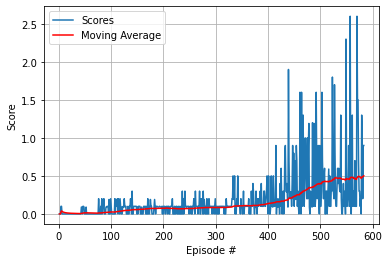

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='Scores')
plt.plot(np.arange(1, len(mov_avgs)+1), mov_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.grid()
plt.show()

When finished, close the environment.

In [10]:
env.close()